## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies

In [5]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Total 510 (delta 0), reused 0 (delta 0), pack-reused 510 (from 1)
Receiving objects: 100% (510/510), 88.46 MiB | 28.41 MiB/s, done.
Resolving deltas: 100% (156/156), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 92.6 kB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [6]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 23.1 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [7]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [8]:
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

### Imports

In [9]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [10]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model





In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

### Results visualisation

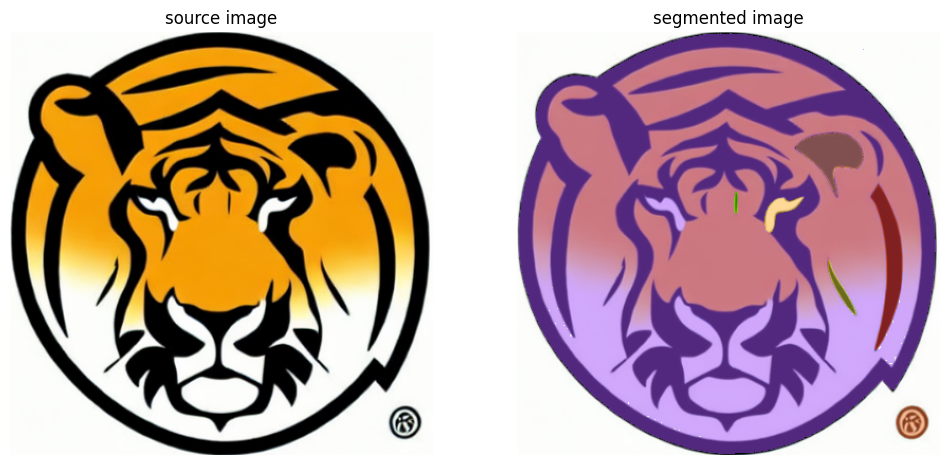

In [247]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

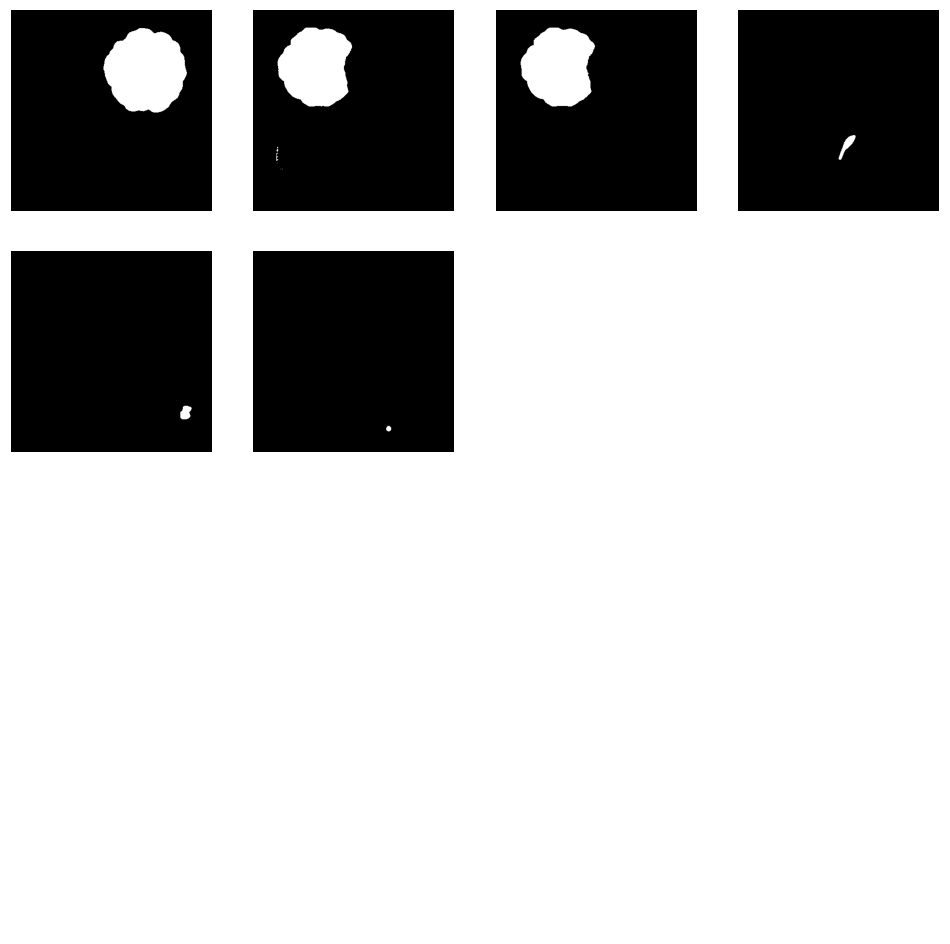

In [138]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

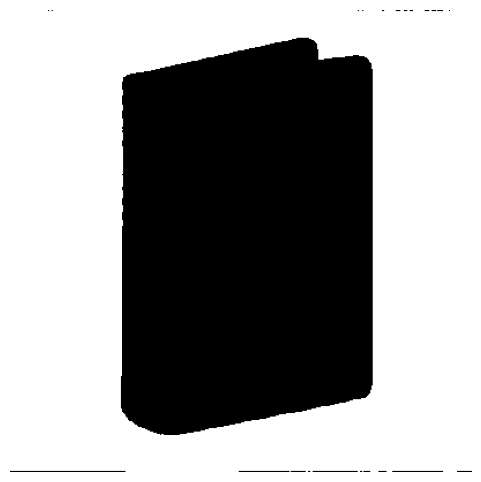

In [55]:
last_image = masks[0]

plt.figure(figsize=(6, 6))
plt.imshow(last_image, cmap='gray')
plt.axis('off')
plt.show()

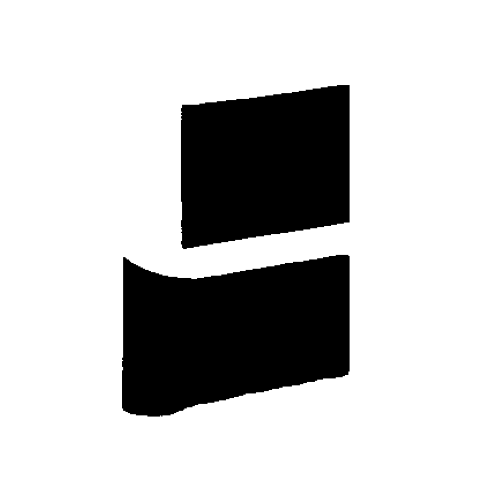

In [101]:
combined_mask = np.logical_or(masks[3], masks[2])

# 마지막 이미지를 불러옵니다 (초기화 상태에서 합치기 위해 사용).
last_image = masks[2]

# last_image와 combined_mask를 논리 OR 연산으로 합칩니다.
final_image = np.logical_or(last_image, combined_mask)

# 결과 이미지를 시각화합니다.
plt.figure(figsize=(6, 6))
plt.imshow(final_image, cmap='gray')
plt.axis('off')
plt.show()


In [102]:
save_folder = './output/'
os.makedirs(save_folder, exist_ok=True)

save_path = os.path.join(save_folder, 'book_cover.png')

plt.imsave(save_path, inverted_image, cmap='gray')

### Advanced automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

In [109]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [110]:
sam2_result_2 = mask_generator_2.generate(image_rgb)

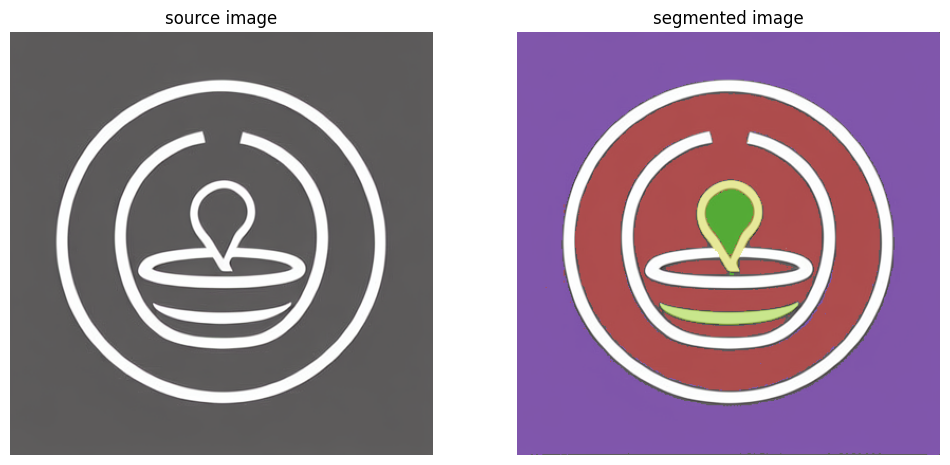

In [111]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Prompting with boxes

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [191]:
predictor = SAM2ImagePredictor(sam2_model)

In [252]:
IMAGE_PATH = f"{HOME}/data/tiger_logo.png"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

### Interactive box prompt

In [253]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to **draw bounding box** on the image 👇

In [254]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [255]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

### Generate masks with SAM

**NOTE:** Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction. `SAM2ImagePredictor.predict` takes the following arguments:

- `point_coords` - `[np.ndarray or None]` - a `Nx2` array of point prompts to the model. Each point is in `(X,Y)` in pixels.
- `point_labels` - `[np.ndarray or None]` - a length `N` array of labels for the
point prompts. `1` indicates a foreground point and `0` indicates a
background point.
- `box` - `[np.ndarray or None]` - a length `4` array given a box prompt to the
model, in `[x_min, y_min, x_max, y_max]` format.
- `mask_input` - `[np.ndarray]` - a low resolution mask input to the model, typically coming from a previous prediction iteration. Has form `1xHxW`, where
for SAM, `H=W=256`.
- `multimask_output` - `[bool]` - if true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, `multimask_output=False` can give better results.
- `return_logits` - `[bool]` - if true, returns un-thresholded masks logits
instead of a binary mask.
- `normalize_coords` - `[bool]` - if true, the point coordinates will be normalized to the range `[0,1]` and point_coords is expected to be wrt. image dimensions.

In [256]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

masks = np.squeeze(masks)

### Results visualisation

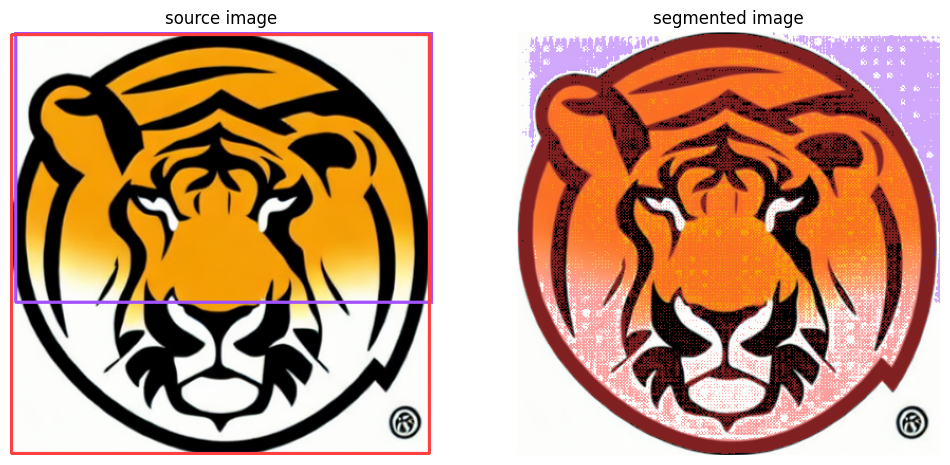

In [257]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool))

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

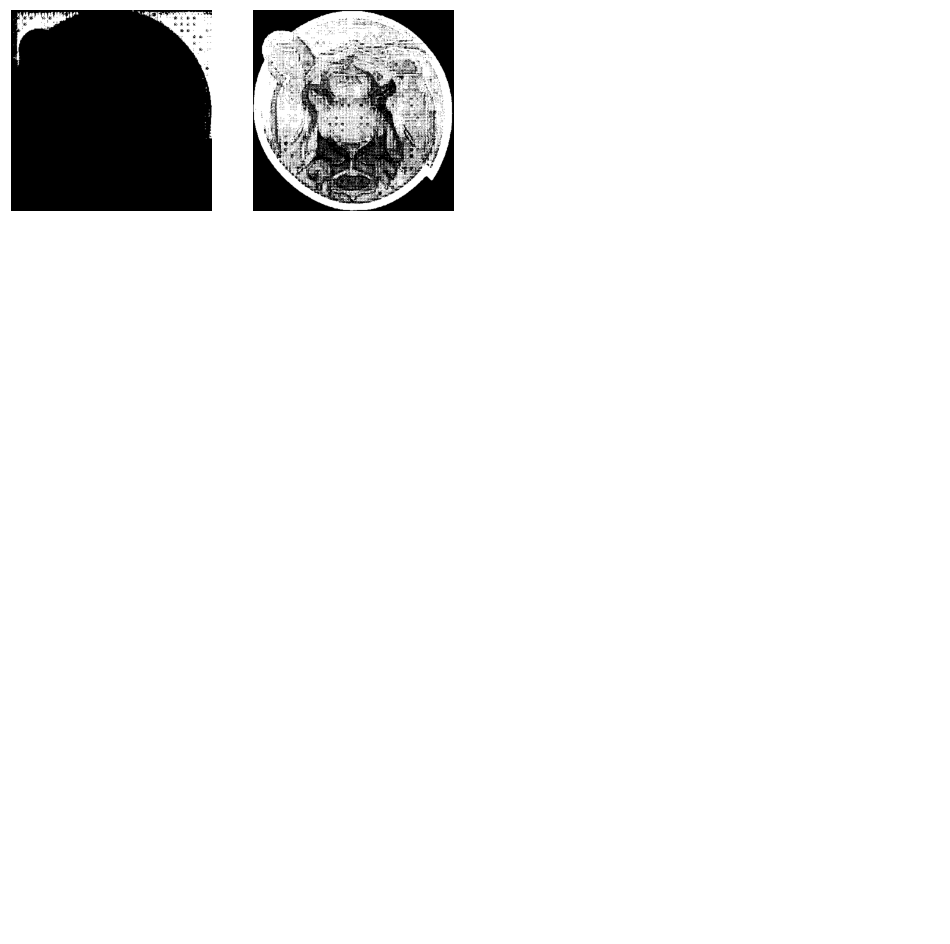

In [258]:
sv.plot_images_grid(
    images=masks[:16],
grid_size=(4, 4),
    size=(12, 12)
)

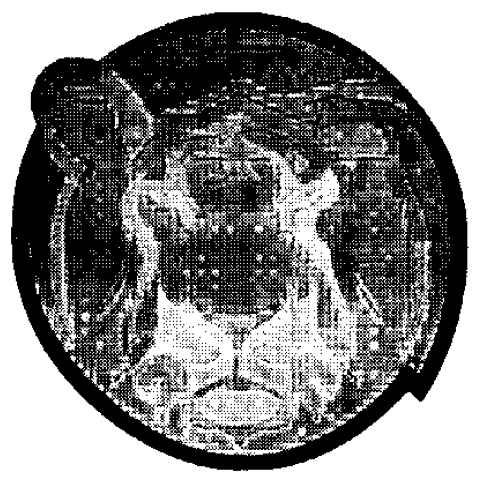

In [266]:
combined_mask = np.logical_or(masks[0], masks[1])
# combined_mask = np.logical_or(combined_mask, masks[2])


# # 마지막 이미지를 불러옵니다 (초기화 상태에서 합치기 위해 사용).
last_image = masks[0]

# # last_image와 combined_mask를 논리 OR 연산으로 합칩니다.
final_image = np.logical_or(last_image, combined_mask)

inverted_image = 1 - masks[1]

# 결과 이미지를 시각화합니다.
plt.figure(figsize=(6, 6))
plt.imshow(inverted_image, cmap='gray')
plt.axis('off')
plt.show()

In [267]:
save_folder = './output/'
os.makedirs(save_folder, exist_ok=True)

save_path = os.path.join(save_folder, 'tiger_logo.png')

plt.imsave(save_path, inverted_image, cmap='gray')

## Prompting with points

**NOTE:** Execute cell below and use your mouse to **draw points** on the image 👇

In [145]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [146]:
widget.bboxes

[{'x': 64, 'y': 115, 'width': 0, 'height': 0, 'label': ''},
 {'x': 238, 'y': 153, 'width': 0, 'height': 0, 'label': ''},
 {'x': 338, 'y': 215, 'width': 0, 'height': 0, 'label': ''}]

In [147]:
default_box = [
    {'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': ''},
    {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
    {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
    {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [148]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

RuntimeError: An image must be set with .set_image(...) before mask prediction.

**NOTE:** With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

In [149]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)

ValueError: The number of images exceeds the grid size. Please increase the grid size or reduce the number of images.

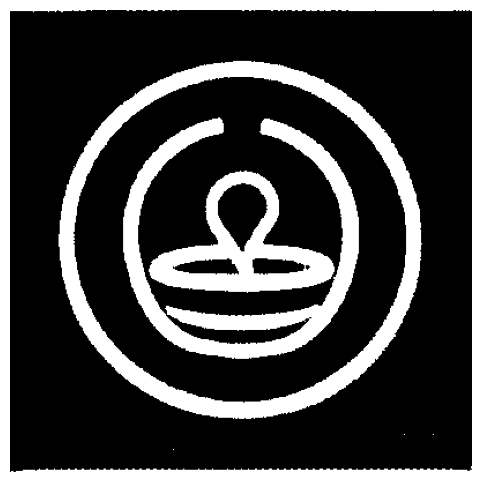

In [134]:
# combined_mask = np.logical_or(masks[3], masks[2])

# 마지막 이미지를 불러옵니다 (초기화 상태에서 합치기 위해 사용).
last_image = masks[1]

# last_image와 combined_mask를 논리 OR 연산으로 합칩니다.
# final_image = np.logical_or(last_image, combined_mask)

inverted_image = 1 - last_image

# 결과 이미지를 시각화합니다.
plt.figure(figsize=(6, 6))
plt.imshow(inverted_image, cmap='gray')
plt.axis('off')
plt.show()

In [135]:
save_folder = './output/'
os.makedirs(save_folder, exist_ok=True)

save_path = os.path.join(save_folder, 'cup_logo_background.png')

plt.imsave(save_path, inverted_image, cmap='gray')